In [3]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [4]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [5]:
import torch
import matplotlib.pyplot as plt
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    HardPhongShader,
    SoftSilhouetteShader,
    BlendParams
)


In [6]:
# based on https://github.com/facebookresearch/pytorch3d/issues/51
def load_untextured_mesh(mesh_path, device):
    mesh = load_objs_as_meshes([mesh_path], device=device)
    verts, faces_idx, _ = load_obj(mesh_path)
    faces = faces_idx.verts_idx
    # Initialize each vertex to be white in color
    verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
    textures = Textures(verts_rgb=verts_rgb.to(device))
    mesh_no_texture = Meshes(
        verts=[verts.to(device)],
        faces=[faces.to(device)],
        textures=textures
        )
    return mesh_no_texture

In [7]:
def render_mesh(mesh, R, T, device, img_size=512, light_loc=[0.0, 5.0, -10.0]):
    cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
    raster_settings = RasterizationSettings(
        image_size=img_size, 
        blur_radius=0.0, 
        faces_per_pixel=1, 
    )
    
    lights = PointLights(device=device, location=[light_loc])
    
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights
        )
    )
    rendered_images = renderer(mesh, cameras=cameras)
    return rendered_images

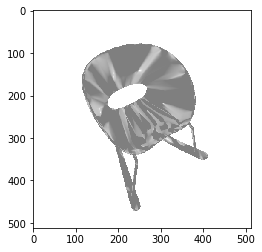

In [21]:
model_name = ["1a74a83fa6d24b3cacd67ce2c72c02e","1ac6531a337de85f2f7628d6bf38bcc4", "1b938d400e1a340b17b431cae0dd70ed","ba45d6c491637dc5820018801b237b3d", "ed751e0c20f48b3226fc87e2982c8a2b","ef4e47e54bfc685cb40f0ac0fb9a650d", "f3e0042ea11660d0ff2c92c2a4f65876", "f9cdefd31b167f95e8f8c11a24c52ebb"]
i=6
obj_model_path = "data/misc/example_shapenet/03001627/{}/model.obj".format(model_name[i])
#obj_model_path = "data/misc/example_shapenet/03001627/{}/model_watertight.obj".format(model_name[i])
device = torch.device("cuda:0")

with torch.no_grad():
    mesh = load_untextured_mesh(obj_model_path, device)
    R, T = look_at_view_transform(1, 50, 55) 
    render = render_mesh(mesh, R, T, device, light_loc=[100,100,100.0])
plt.imshow(render[0, ..., :3].cpu().numpy())


In [2]:
i=0
for j in range(100): i-=1
print(i)

-100
